In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import string
import contractions
import re
from nltk.corpus import stopwords
import time
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

In [2]:
plt.style.use('fivethirtyeight')
ps = PorterStemmer()

In [3]:
df = pd.read_csv('whatssap_reviews.csv')

In [4]:
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,8558878b-0b44-4bc2-a2c4-25a94f8b47a0,Ereny Eshak,this app is very bad i don't like it,1,3,2.24.10.79,2024-05-29 17:45:53,2.24.10.79
1,07dc4cad-47bb-46ca-98ec-872877e30b44,Rohit Pandit,WhatsApp is used for chat and call audio & viedo,2,5,2.24.10.85,2024-05-29 13:15:11,2.24.10.85
2,b5d3e023-4e9a-4711-b6cc-11b188b19d35,Asad Linda baloch,Asadali,3,4,2.24.10.85,2024-05-29 12:58:52,2.24.10.85
3,0688d54b-fa4f-48bc-ac7d-e1f64805d065,Samrat Mandi,Samrat mnadi,5,5,2.24.10.85,2024-05-29 12:46:28,2.24.10.85
4,765c2d38-bbe9-44bc-b1d8-3f1649188432,Moowiid Moowiid,moowid,2,6,2.24.10.85,2024-05-29 12:06:49,2.24.10.85


In [5]:
df.shape

(225876, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225876 entries, 0 to 225875
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              225876 non-null  object
 1   userName              225874 non-null  object
 2   content               225863 non-null  object
 3   score                 225876 non-null  int64 
 4   thumbsUpCount         225876 non-null  int64 
 5   reviewCreatedVersion  205697 non-null  object
 6   at                    225876 non-null  object
 7   appVersion            205697 non-null  object
dtypes: int64(2), object(6)
memory usage: 13.8+ MB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
score,225876.0,3.423542,1.691237,1.0,1.0,4.0,5.0,5.0
thumbsUpCount,225876.0,71.735018,1221.980961,0.0,0.0,0.0,1.0,118676.0


In [8]:
df.describe(include='object').T

,count,unique,top,freq
reviewId,225876,211388,5acecfca-3543-45b4-9b48-9657139f5147,6
userName,225874,187068,A Google user,11338
content,225863,167640,good,7632
reviewCreatedVersion,205697,659,2.24.9.78,49506
at,225876,206071,2024-05-17 06:59:52,9
appVersion,205697,659,2.24.9.78,49506


# Data Cleansing
Data cleansing starts with cleaning null values, then removing duplicate values in the dataset, as well as removing variables that are out of the topic. Additionally, creating a new variable called Rate_Label, which contains values from 0 to 2, where 0 represents negative, 1 represents neutral, and 2 represents positive sentiment.

In [9]:
df.isnull().sum()

reviewId                    0
userName                    2
content                    13
score                       0
thumbsUpCount               0
reviewCreatedVersion    20179
at                          0
appVersion              20179
dtype: int64

In [10]:
df.duplicated().sum()

13725

In [11]:
df[df.duplicated()]

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
87949,95b4c571-c584-46fb-b41f-d66cfa377812,Shahrukh Vora,best,5,0,2.24.8.85,2024-05-17 12:05:33,2.24.8.85
87950,ba6ffbaa-be27-48a5-bcdc-0bae3f936c49,SURAJ LAL,super,5,0,2.24.7.81,2024-05-17 12:05:31,2.24.7.81
87951,61a15dfb-225d-4846-afb2-907d187f013b,Aryan Kamble,very helpful 😃,5,0,2.24.9.78,2024-05-17 12:05:27,2.24.9.78
87952,f356a7a7-0c8d-4836-b864-7fba6900f00e,Shivaprasad Rajsagar,Excellent,5,0,2.24.9.78,2024-05-17 12:05:19,2.24.9.78
87953,85f9ef85-1805-4b1d-b058-75ce10226089,Sriram Sriram,super,5,0,2.24.9.78,2024-05-17 12:05:13,2.24.9.78
...,...,...,...,...,...,...,...,...
114431,e4596bf0-693e-4aa1-b853-3eea53140e51,Akhilesh Kumar Sharma,Very bad,1,0,2.24.9.78,2024-05-12 00:03:34,2.24.9.78
114432,97923309-c554-4499-a092-8f668f3f3837,Conmanix Kutya,Working good and friendly user,5,0,2.24.2.76,2024-05-12 00:02:56,2.24.2.76
114433,3e69c425-ec50-48c8-bbba-5b2bc50b078e,Ayanwoye Emmanuel,It's fun 😊,5,0,2.24.8.85,2024-05-12 00:01:17,2.24.8.85
114434,dac8d241-b340-4e08-bb71-8d764effb2c2,Usha Nandini,Its good,3,0,2.24.9.78,2024-05-12 00:01:12,2.24.9.78


In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(212151, 8)

In [14]:
df=df[['content','score','thumbsUpCount','at']]

In [15]:
df.head()

,content,score,thumbsUpCount,at
0,this app is very bad i don't like it,1,3,2024-05-29 17:45:53
1,WhatsApp is used for chat and call audio & viedo,2,5,2024-05-29 13:15:11
2,Asadali,3,4,2024-05-29 12:58:52
3,Samrat mnadi,5,5,2024-05-29 12:46:28
4,moowid,2,6,2024-05-29 12:06:49


In [16]:
df['at'] = pd.to_datetime(df['at'])


In [17]:
df['at'] = df['at'].dt.strftime('%Y')

In [18]:
df.head()

,content,score,thumbsUpCount,at
0,this app is very bad i don't like it,1,3,2024
1,WhatsApp is used for chat and call audio & viedo,2,5,2024
2,Asadali,3,4,2024
3,Samrat mnadi,5,5,2024
4,moowid,2,6,2024


In [19]:
df = df.rename(columns={'content': 'Review', 'score': 'Rate','thumbsUpCount':'Like','at':'Year'})

In [20]:
df.head()

,Review,Rate,Like,Year
0,this app is very bad i don't like it,1,3,2024
1,WhatsApp is used for chat and call audio & viedo,2,5,2024
2,Asadali,3,4,2024
3,Samrat mnadi,5,5,2024
4,moowid,2,6,2024


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212151 entries, 0 to 225875
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  212142 non-null  object
 1   Rate    212151 non-null  int64 
 2   Like    212151 non-null  int64 
 3   Year    212151 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.1+ MB


In [22]:
df.isnull()
total_null_values = df.isnull().sum().sum()
print("Total null values in the DataFrame:", total_null_values)

Total null values in the DataFrame: 9


In [23]:
df[df['Review'].isnull()]

,Review,Rate,Like,Year
22561,NaN,5,0,2024
31927,NaN,5,0,2024
36318,NaN,5,0,2024
38311,NaN,5,0,2024
56122,NaN,5,0,2024
72582,NaN,5,0,2024
74489,NaN,5,0,2024
83135,NaN,5,0,2024
110627,NaN,5,0,2024


In [24]:
df = df[~df['Review'].isnull()]

In [25]:
df.shape

(212142, 4)

In [26]:
def target_labeler(rating):
    if(rating>=4):
        return 2
    elif(rating==3):
        return 1
    return 0

In [27]:
df['Rate_Label'] = df['Rate'].apply(target_labeler)

- Removing NaN values is done to ensure that there is no missing information in the subsequent processes.
- The removal of variables reviewID, userName,   reviewCreatedVersion, and appVersion is conducted because those variables are far from the topic of interest.
- The creation of the Rate_Label variable is performed to understand the sentiment trend from users.

# Feature Engineering
In this process, the creation of the Year variable is based on the year of the review, preprocessing of user reviews to make them easier to process, and the addition of variables indicating the number of words and letters in each review.

In [28]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [29]:
def preprocess_text(text):
    #remove html tags
    text = re.compile(r'<[^>]+>').sub('', text)
    # convert to lower case 
    text = text.lower()
    # expand contractions
    text = contractions.fix(text)
    # remove punctuations 
    text = text.translate(str.maketrans('','', string.punctuation))
    # remove numbers 
    text = ''.join([i for i in text if not i.isdigit()])
    # remove stop words
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
    # perform stemming
    text = text.split()
    words = []
    for word in text:
        words.append(ps.stem(word))
    text = ' '.join(words)
    # remove emoji
    text = remove_emoji(text)
    # remove extra spaces
    text = ' '.join(text.split())
    return text

In [30]:
start_time = time.time()
df['Review'] = df['Review'].apply(preprocess_text)
print(time.time()-start_time)

681.7428796291351


- The Year variable is needed to facilitate the exploration of trends in positive or negative reviews and to simplify the machine's learning process for the model creation later on.
- The creation of the Word and Char variables is used to assist the model in understanding the relationships between variables.

In [31]:
w = []
c = []
def create_new_features(text):
    words = text.split()
    char_len = 0
    for word in words:
        char_len += len(word)
    w.append(len(words))
    c.append(char_len)
    return (len(words), char_len)

In [32]:
df['Review'].apply(create_new_features)

0           (3, 10)
1           (6, 29)
2            (1, 7)
3           (2, 11)
4            (1, 6)
            ...    
225871     (10, 50)
225872     (19, 89)
225873    (26, 148)
225874     (16, 92)
225875     (18, 79)
Name: Review, Length: 212142, dtype: object

In [33]:
df['Word'] = w
df['Char'] = c

In [34]:
df['Char'],df['Rate_Label'] = df['Rate_Label'],df['Char']
df.rename(columns={
    'Char':'Rate_Label',
    'Rate_Label':'Char'
}, inplace=True)


In [35]:
df['Year'].value_counts().sort_index()

Year
2014         1
2016         1
2018      1483
2019      5994
2020      9641
2021      9138
2022      8411
2023     18554
2024    158919
Name: count, dtype: int64

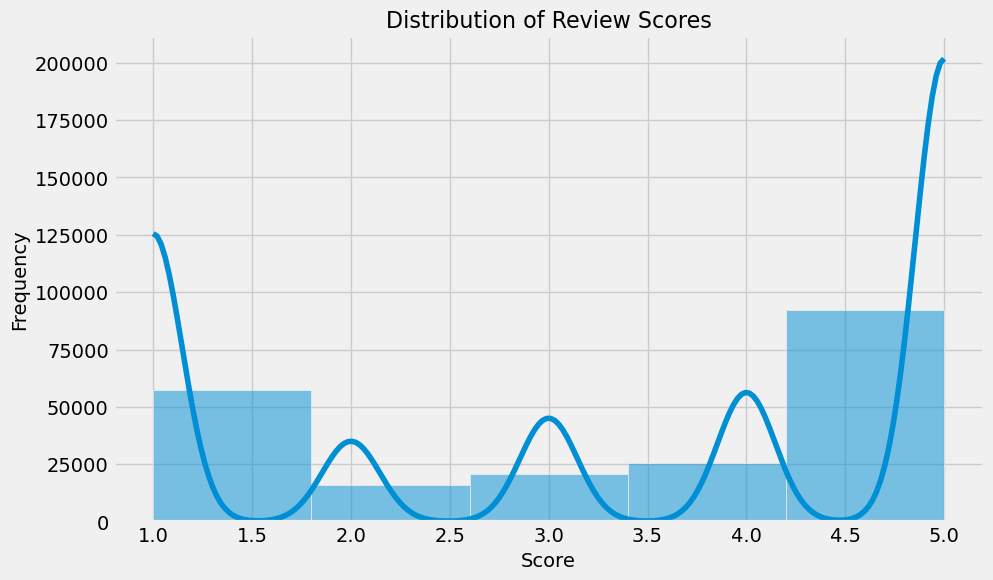

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Rate'], bins=5, kde=True,)
plt.title('Distribution of Review Scores', fontsize=16)
plt.xlabel('Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

The distribution of review scores indicates how users perceive the WhatsApp application. A large number of reviews with a score of 5 suggest that the majority of users are highly satisfied with the application and have provided positive feedback. However, the presence of reviews with a score of 1 suggests that there are also users who are dissatisfied with the application and have provided negative feedback. This distribution highlights the variability in user opinions, ranging from very positive to very negative, regarding their experiences with the WhatsApp application.

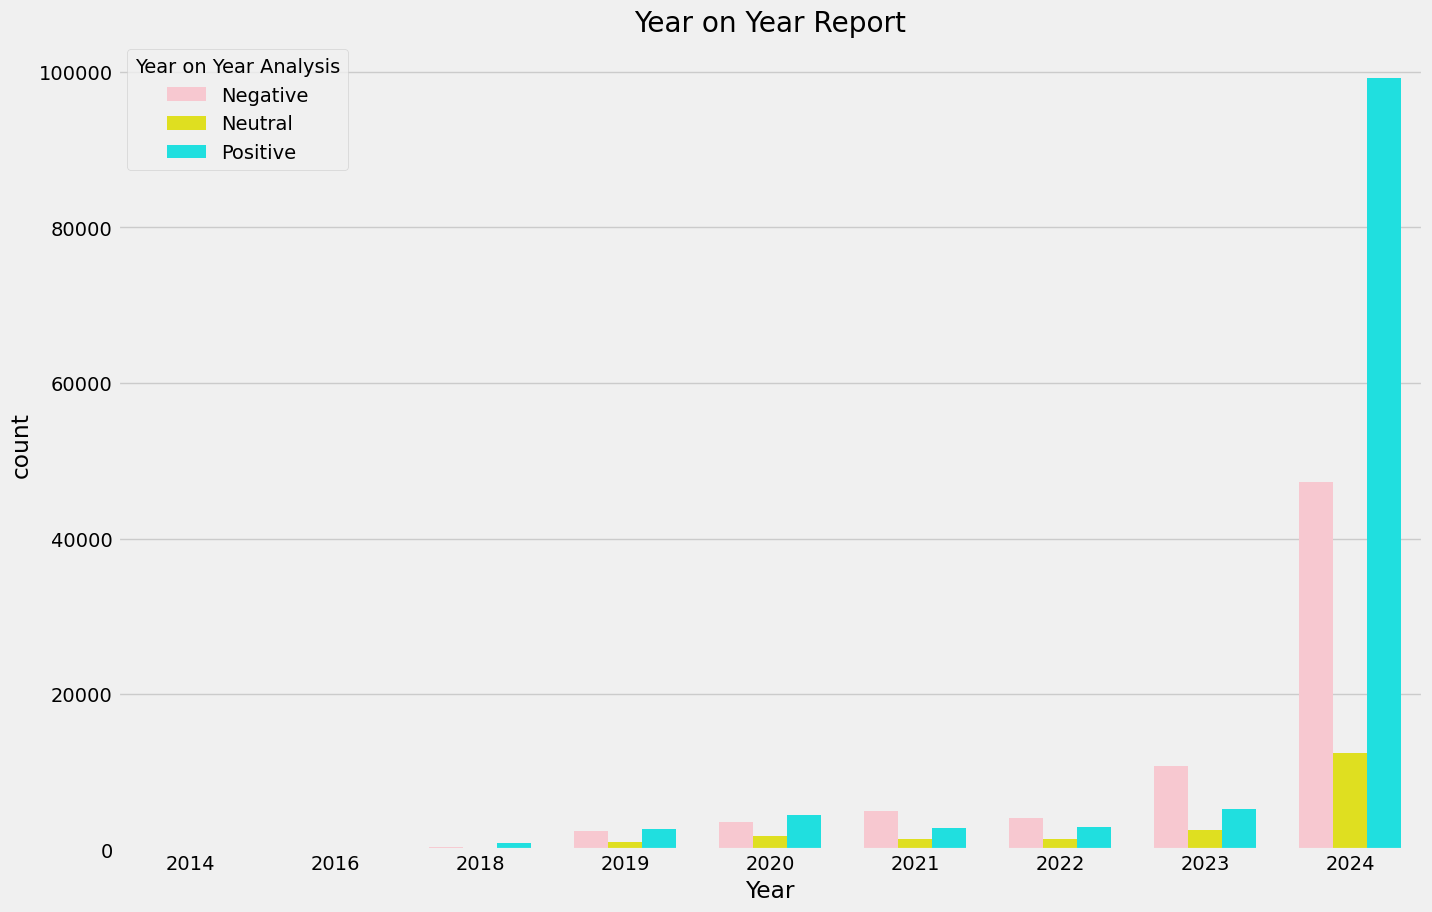

In [39]:
plt.figure(figsize=(15,10))
temp_df = df[['Year','Rate_Label']].sort_values(by='Year')
plot = sns.countplot(data=temp_df, x='Year', hue='Rate_Label', width=0.7, palette=['pink', 'yellow', 'cyan'])
plot.legend(title='Year on Year Analysis', labels=['Negative', 'Neutral', 'Positive'])
plt.title('Year on Year Report')
plt.show()

- This indicates that in 2024, users began to trust the performance of the WhatsApp application more. This trust may have been influenced by updates and features such as increased group chat capacity and additional features for group video calls and group calls.

- From 2019 to 2023, the period marked by the pandemic and post-pandemic era, quarantine measures were implemented, requiring work, school, and other activities to be conducted online. WhatsApp was one of the applications significantly impacted during this time, with a surge in user numbers. However, during these years, the features provided did not adequately meet users' needs. Limitations included the maximum group chat size, video calls restricted to 2 to 4 participants, and group calls also being limited. These constraints contributed to users giving low ratings or negative reviews for the WhatsApp application.

In [56]:
stopwords = set(STOPWORDS)
negative_reviews = ' '.join(df[df['Rate_Label'] == 0]['Review'])
positive_reviews = ' '.join(df[df['Rate_Label'] == 2]['Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(negative_reviews)

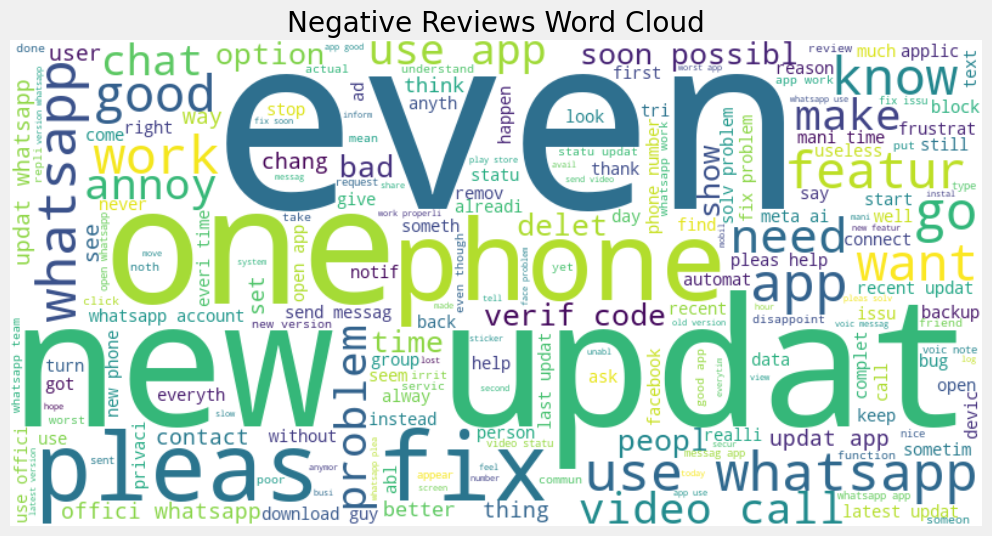

In [40]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud')
plt.show()

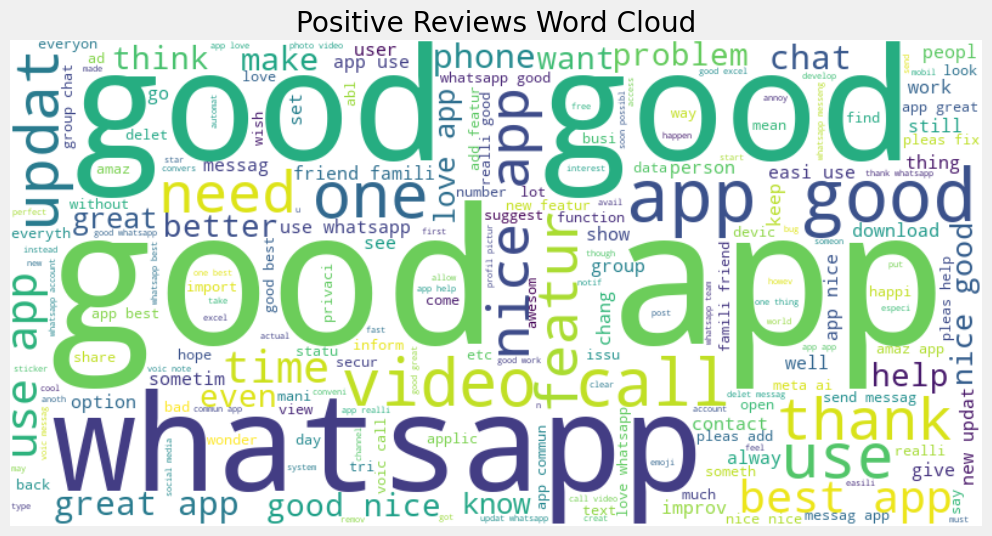

In [58]:
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(positive_reviews)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

- Negative review keywords that stand out include 'New Update', 'Fix', 'Feature', 'Work', 'Solve Problem', 'Fix Problem', 'Chat', 'Option', and 'Video Call'.
- Positive review keywords that stand out include 'good', 'nice', 'improve', 'video call', 'feature', and 'update'.

In [41]:
df[df['Rate_Label']==0]

,Review,Rate,Like,Year,Char,Word,Rate_Label
0,app bad like,1,3,2024,10,3,0
1,whatsapp use chat call audio viedo,2,5,2024,29,6,0
4,moowid,2,6,2024,6,1,0
6,طیب أردگان thank 🥰,1,4,2024,15,4,0
9,raj,1,4,2024,3,1,0
...,...,...,...,...,...,...,...
225867,new updat restor resourc bug say hundr percent...,1,9,2021,81,16,0
225868,cannot upgrad version expir tri everi possibl ...,2,1,2020,80,15,0
225869,disagre privat polici shift anoth messag appli...,1,0,2021,94,18,0
225873,whatsapp facebook messag share similar featur ...,2,1,2020,148,26,0


In [42]:
def categorise_year_feature(year):
    year = int(year)
    if year >= 2023:
        return 0
    elif year >=2019:
        return 1
    else:
        return 2

df['Year'] = df['Year'].apply(categorise_year_feature)

In [43]:
df.head()

,Review,Rate,Like,Year,Char,Word,Rate_Label
0,app bad like,1,3,0,10,3,0
1,whatsapp use chat call audio viedo,2,5,0,29,6,0
2,asadali,3,4,0,7,1,1
3,samrat mnadi,5,5,0,11,2,2
4,moowid,2,6,0,6,1,0


In [44]:
df=df.drop(columns='Rate')

# Modelling
The model formation process will be carried out using the following models:
- MultinomialNB (mnc)
- BernoulliNB (bnc)
- DecisionTreeClassifier (dtc)
- RandomForestClassifier (rfc)
- ExtraTreesClassifier (etc)
- AdaBoostClassifier (abc)
These models will be evaluated based on their accuracy and precision scores.

In [45]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score


In [47]:
# Convert text to features using TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Review'])
y = df['Rate_Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [48]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier


In [49]:
mnc = MultinomialNB()
bnc = BernoulliNB()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
abc = AdaBoostClassifier(n_estimators=50, random_state=42)


In [50]:
classfiers = {
    
    'MultinomialNB': mnc,
    'BernoulliNB': bnc,
    'DecisionTreeClassifier': dtc,
    'RandomForestClassifier':rfc,
    'ExtraTreesClassifier':etc,
    'AdaBoostClassifier':abc,
 
}
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score

def train_model(clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    p_score = precision_score(y_test, y_pred, average='weighted')
    kf_score = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
    return str(score*100)+'%' , str(p_score*100)+'%', str(kf_score.mean()*100)+'%'

In [51]:
accuracy = []
precision = []

# Training and evaluating each model
for name, classifier in classfiers.items():
    print(f"Training {name}...")
    if name in ['GaussianNB']:  # GaussianNB does not accept sparse matrices directly
        classifier.fit(X_train.toarray(), y_train)
        y_pred = classifier.predict(X_test.toarray())
    else:
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    
    accuracy.append((name, acc))
    precision.append((name, prec))
    
    print(f"{name} Accuracy: {acc * 100:.2f}%")
    print(f"{name} Precision: {prec * 100:.2f}%")
    print("-----")

# Displaying overall results
print("\nOverall Accuracy:")
for name, acc in accuracy:
    print(f"{name}: {acc * 100:.2f}%")

print("\nOverall Precision:")
for name, prec in precision:
    print(f"{name}: {prec * 100:.2f}%")

Training MultinomialNB...
MultinomialNB Accuracy: 75.37%
MultinomialNB Precision: 69.59%
-----
Training BernoulliNB...
BernoulliNB Accuracy: 69.31%
BernoulliNB Precision: 66.68%
-----
Training DecisionTreeClassifier...
DecisionTreeClassifier Accuracy: 67.93%
DecisionTreeClassifier Precision: 65.67%
-----
Training RandomForestClassifier...
RandomForestClassifier Accuracy: 75.20%
RandomForestClassifier Precision: 69.45%
-----
Training ExtraTreesClassifier...
ExtraTreesClassifier Accuracy: 75.16%
ExtraTreesClassifier Precision: 69.86%
-----
Training AdaBoostClassifier...
AdaBoostClassifier Accuracy: 71.98%
AdaBoostClassifier Precision: 67.27%
-----

Overall Accuracy:
MultinomialNB: 75.37%
BernoulliNB: 69.31%
DecisionTreeClassifier: 67.93%
RandomForestClassifier: 75.20%
ExtraTreesClassifier: 75.16%
AdaBoostClassifier: 71.98%

Overall Precision:
MultinomialNB: 69.59%
BernoulliNB: 66.68%
DecisionTreeClassifier: 65.67%
RandomForestClassifier: 69.45%
ExtraTreesClassifier: 69.86%
AdaBoostClassi

In [53]:
score_comparison = pd.DataFrame({'Model': classfiers.keys(), 'Accuracy': accuracy, 'Precision': precision})

In [54]:
score_comparison 

,Model,Accuracy,Precision
0,MultinomialNB,"(MultinomialNB, 0.753706191519951)","(MultinomialNB, 0.6958515554367312)"
1,BernoulliNB,"(BernoulliNB, 0.6931108439982088)","(BernoulliNB, 0.6668038261054319)"
2,DecisionTreeClassifier,"(DecisionTreeClassifier, 0.6792523981239247)","(DecisionTreeClassifier, 0.6567159874788875)"
3,RandomForestClassifier,"(RandomForestClassifier, 0.7520328077494167)","(RandomForestClassifier, 0.694502203750418)"
4,ExtraTreesClassifier,"(ExtraTreesClassifier, 0.7516321383959085)","(ExtraTreesClassifier, 0.6985781462944427)"
5,AdaBoostClassifier,"(AdaBoostClassifier, 0.7197671403992553)","(AdaBoostClassifier, 0.6726901489614825)"


The model selection was based on the highest accuracy and precision scores. Therefore, the model that was found to be the most suitable for representing this sentiment analysis is the Multinomial Naive Bayes model, with an accuracy of 75.37% and a precision of 69.58%. The Random Forest and Extra Trees Classifiers also proved to be quite suitable for this sentiment analysis case.